# Kaggle GI Tract Train

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create simple model for first submission - done
* Add some augmentation transforms (https://github.com/albumentations-team/albumentations)
    * rotation (10 deg)
    * resize
* Extend training epochs

* remove bad data https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/321979



* Go to 2.5 D method  - check if providing repeat image vs padding is better when making 2.5 d image - makes no difference

* try multi-class single label 




* Go to 3D method




* add Hausdorff metric https://github.com/mavillan/py-hausdorff
https://www.kaggle.com/code/carnozhao/tract-competiton-metrics



In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

from tqdm.notebook import tqdm

#import albumentations as A
from torchvision import transforms



#DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

MODEL_FOLDER = DATASET_FOLDER/"kaggle models"
os.makedirs(MODEL_FOLDER, exist_ok=True)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

model_name_base = "Unet-4b"

# Data

## Process the Metadata

In [2]:
df2d = pd.read_csv(DATASET_FOLDER/"df2d_metadata.csv",index_col = [0])
display(df2d.head())

large_bowel small_bowel stomach                        id case_id_str  \
0         NaN         NaN     NaN  case101_day20_slice_0001     case101   
1         NaN         NaN     NaN  case101_day20_slice_0002     case101   
2         NaN         NaN     NaN  case101_day20_slice_0003     case101   
3         NaN         NaN     NaN  case101_day20_slice_0004     case101   
4         NaN         NaN     NaN  case101_day20_slice_0005     case101   

   case_id day_num_str  day_num    slice_id  slice_num  \
0      101       day20       20  slice_0001          1   
1      101       day20       20  slice_0002          2   
2      101       day20       20  slice_0003          3   
3      101       day20       20  slice_0004          4   
4      101       day20       20  slice_0005          5   

                                    match  \
0  case101/case101_day20/scans/slice_0001   
1  case101/case101_day20/scans/slice_0002   
2  case101/case101_day20/scans/slice_0003   
3  case101/case101_day20/scans/slice_0004   
4  case101/case101_day20/scans/slice_0005   

                                             subpath  \
0  case101/case101_day20/scans/slice_0001_266_266...   
1  case101/case101_day20/scans/slice_0002_266_266...   
2  case101/case101_day20/scans/slice_0003_266_266...   
3  case101/case101_day20/scans/slice_0004_266_266...   
4  case101/case101_day20/scans/slice_0005_266_266...   

                           filename  im_height  im_width  im_pixel_height  \
0  slice_0001_266_266_1.50_1.50.png        266       266              1.5   
1  slice_0002_266_266_1.50_1.50.png        266       266              1.5   
2  slice_0003_266_266_1.50_1.50.png        266       266              1.5   
3  slice_0004_266_266_1.50_1.50.png        266       266              1.5   
4  slice_0005_266_266_1.50_1.50.png        266       266              1.5   

   im_pixel_width  slice_thickness  segmentations  fold  
0             1.5              3.0          False   4.0  
1             1.5              3.0          False   4.0  
2             1.5              3.0          False   4.0  
3             1.5              3.0          False   4.0  
4             1.5              3.0          False   4.0

In [3]:
df2d.columns

Index(['large_bowel', 'small_bowel', 'stomach', 'id', 'case_id_str', 'case_id',
       'day_num_str', 'day_num', 'slice_id', 'slice_num', 'match', 'subpath',
       'filename', 'im_height', 'im_width', 'im_pixel_height',
       'im_pixel_width', 'slice_thickness', 'segmentations', 'fold'],
      dtype='object')

### Get pixel scaling info from 3D scans

In [4]:
pil_to_tensor = transforms.ToTensor()

In [5]:
def image_max(subpath):
    img_path = TRAIN_FOLDER/subpath
    img = pil_to_tensor(Image.open(img_path))
    #stat = img.max().item()
    stat = (img.flatten()*1.0).quantile(0.75).item()
    return stat

In [6]:
#find the max pixel intensity for each image
df2d['max'] = df2d['subpath'].apply(image_max)

In [7]:
#group by the slice (same case_id and day_num)
#make a transform
d = df2d.groupby(['case_id' ,'day_num'])['max'].transform('max')

In [8]:
#add to the dataframe
df2d['max_img'] = d

### Identify neighboring slices

In [9]:
skip = 2

res_dict={'subpath_plus':[],'subpath_minus':[]}

list_len = df2d.shape[0]
pbar = tqdm(total=list_len)

for idx in range(0,list_len):
    row = df2d.iloc[idx]
    case = row['case_id']
    day = row['day_num']
    subpath = row['subpath']
    
    #print('idx=',idx,'case:',case, 'day:', day)
    
    idxp = idx + skip
    idxm = idx - skip
    
    if idxp < list_len:
        row_plus = df2d.iloc[idxp]
        case_plus = row_plus['case_id']
        day_plus = row_plus['day_num']
        subpath_plus = row_plus['subpath']
        #print('idxp:',idxp,'case:',case_plus, 'day:', day_plus)
        
        if (case_plus == case) & (day_plus == day):
            
            #df2d.iloc[idx]['plus_subpath'] = subpath_plus
            res_dict['subpath_plus'].append(subpath_plus)
            #print('+',df2d.iloc[idx]['plus_subpath'],subpath_plus)
        else:
            res_dict['subpath_plus'].append("")
    else:
        res_dict['subpath_plus'].append("")
            
    if idxm >= 0:
        row_minus = df2d.iloc[idxm]
        case_minus = row_minus['case_id']
        day_minus = row_minus['day_num']
        subpath_minus = row_minus['subpath']
        #print('idxm:',idxm,'case:',case_minus, 'day:', day_minus)
        if (case_minus == case) & (day_minus == day):
            
            #df2d.iloc[idx]['minus_subpath'] = subpath_minus 
            res_dict['subpath_minus'].append(subpath_minus)
            #print('+',subpath_minus)
            
        else:
            res_dict['subpath_minus'].append("")
    else:
        res_dict['subpath_minus'].append("")
    
    #print('---')
    pbar.update(1)
    
pbar.close()

  0%|          | 0/38496 [00:00<?, ?it/s]

In [10]:
res_df=pd.DataFrame(res_dict)

In [11]:
df25d = pd.concat([df2d,res_df],axis=1)

In [12]:
df25d[['subpath_minus','subpath','subpath_plus']]

subpath_minus  \
0                                                          
1                                                          
2      case101/case101_day20/scans/slice_0001_266_266...   
3      case101/case101_day20/scans/slice_0002_266_266...   
4      case101/case101_day20/scans/slice_0003_266_266...   
...                                                  ...   
38491  case9/case9_day22/scans/slice_0138_360_310_1.5...   
38492  case9/case9_day22/scans/slice_0139_360_310_1.5...   
38493  case9/case9_day22/scans/slice_0140_360_310_1.5...   
38494  case9/case9_day22/scans/slice_0141_360_310_1.5...   
38495  case9/case9_day22/scans/slice_0142_360_310_1.5...   

                                                 subpath  \
0      case101/case101_day20/scans/slice_0001_266_266...   
1      case101/case101_day20/scans/slice_0002_266_266...   
2      case101/case101_day20/scans/slice_0003_266_266...   
3      case101/case101_day20/scans/slice_0004_266_266...   
4      case101/case101_day20/scans/slice_0005_266_266...   
...                                                  ...   
38491  case9/case9_day22/scans/slice_0140_360_310_1.5...   
38492  case9/case9_day22/scans/slice_0141_360_310_1.5...   
38493  case9/case9_day22/scans/slice_0142_360_310_1.5...   
38494  case9/case9_day22/scans/slice_0143_360_310_1.5...   
38495  case9/case9_day22/scans/slice_0144_360_310_1.5...   

                                            subpath_plus  
0      case101/case101_day20/scans/slice_0003_266_266...  
1      case101/case101_day20/scans/slice_0004_266_266...  
2      case101/case101_day20/scans/slice_0005_266_266...  
3      case101/case101_day20/scans/slice_0006_266_266...  
4      case101/case101_day20/scans/slice_0007_266_266...  
...                                                  ...  
38491  case9/case9_day22/scans/slice_0142_360_310_1.5...  
38492  case9/case9_day22/scans/slice_0143_360_310_1.5...  
38493  case9/case9_day22/scans/slice_0144_360_310_1.5...  
38494                                                     
38495                                                     

[38496 rows x 3 columns]

In [13]:
#df25d.to_csv(DATASET_FOLDER/"df25d_metadata.csv")

## Create a Pytorch Dataset

In [14]:
#df25d = pd.read_csv(DATASET_FOLDER/"df25d_metadata.csv",index_col = [0])

In [15]:
#df25d[['subpath_minus','subpath','subpath_plus']]=df25d[['subpath_minus','subpath','subpath_plus']].fillna('')

In [16]:
class Dataset_2_5_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, joint_transform=None, image_transform=None, mask_transform=None,ret_idx=False):
        self.df = df
        self.path = path
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.ret_idx = ret_idx
        self.pil_to_tensor = transforms.ToTensor()
        
        

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        
        
        
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        
        #scale image using stats from whole 3D image
        img = img / (row['max_img']*5) # factor to make sure we don't clip
        #print(row['max_img'])
        #img = Image.open(img_path)
        #print(img.shape)
        #print(img.dtype)
        img3 = torch.zeros((3, img.shape[1], img.shape[2]),dtype=torch.float32)
        mask = torch.zeros((4, img.shape[1], img.shape[2]))
        
        img3[1,:,:] = img
        
        if len(row.subpath_minus) > 0:
            img = self.pil_to_tensor(Image.open(self.path/row.subpath_minus))
            img = img / (row['max_img']*5) # factor to make sure we don't clip
            img3[0,:,:] = img
 
        if len(row.subpath_plus) > 0:
            img = self.pil_to_tensor(Image.open(self.path/row.subpath_plus))
            img = img / (row['max_img']*5) # factor to make sure we don't clip
            img3[2,:,:] = img
            
        
        
        
        if self.image_transform:
            img3 = self.image_transform(img3)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        
        mask[3,:,:] = 1.0*((mask[0,:,:] + mask[1,:,:] + mask[2,:,:])==0)

            
        if self.mask_transform:
            mask = self.mask_transform(mask)       
        
        if self.joint_transform:            
            image_stack = torch.cat([img3, mask], dim=0)
            image_stack = self.joint_transform(image_stack)
            img = image_stack[0:3]
            mask = image_stack[3:7]
        

    
        if self.ret_idx:
            return {"image": img3, "mask": mask, "idx":row.ilocid}
        else:
            return {"image": img3, "mask": mask}
        
        
    
    


In [46]:
def plot_data(d):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    #mx = (d['image'].squeeze().flatten()*1.0).quantile(0.75).numpy()
    #print("median=",mx)
    #img = d['image'].squeeze().numpy()   #/(mx *4)
    #img = img * (img<.1)*100
    
    #mx=16000
    plt.imshow(rearrange(d['image'].numpy(),'c h w -> h w c'), vmin=0, vmax=1.0, aspect=ratio)
    plt.title(f"Image Shape= {d['image'].shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(d['image'][1].numpy(),cmap='gray', vmin=0, vmax=1.0,aspect=ratio)
    plt.imshow(rearrange(d['mask'][0:3,:,:].numpy(),'c h w -> h w c'), vmin=0, vmax=1.0,  alpha=.5, aspect=ratio)
    plt.title(f"Mask Shape = {d['mask'].shape}")
    
    
    plt.axis('off')

In [18]:
dataset = Dataset_2_5_from_df(df25d,TRAIN_FOLDER)

In [19]:
#### plot_data(dataset[19024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


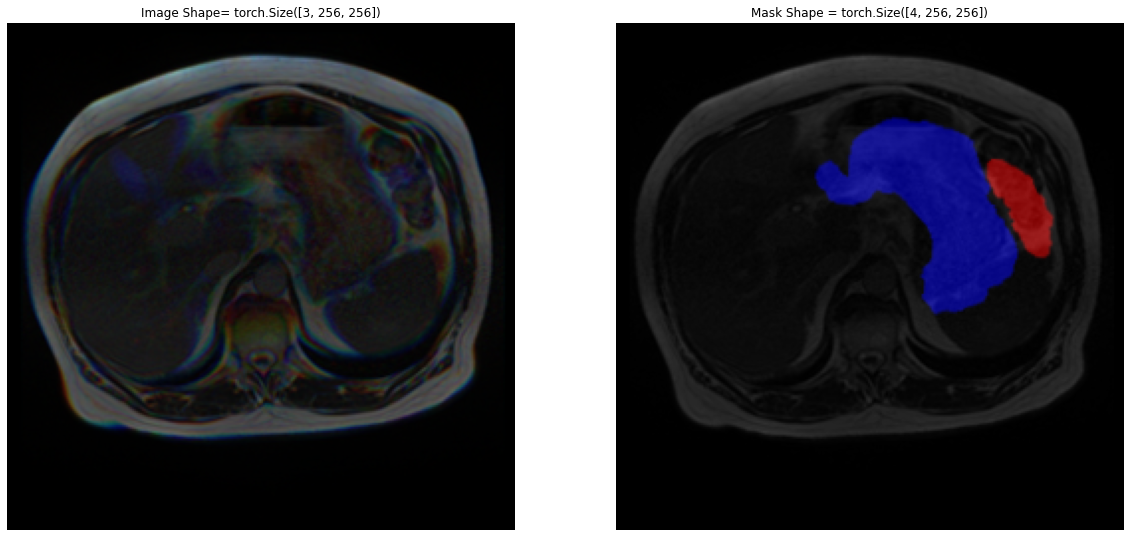

In [47]:
plot_data(dataset[360])

In [21]:
dataload= torch.utils.data.DataLoader(dataset=dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=False)

In [22]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')        
        

In [23]:
### Write transform that takes a 32 bit image and turns into a float 0-1 bit image.

In [24]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

train_transforms = transforms.Compose(
    [transforms.RandomRotation(4, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomPerspective(distortion_scale=.2, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
    
    ])

scale_transforms = transforms.Compose(
    [transforms.Normalize(0,1),
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet


In [25]:
dataset = Dataset_2_5_from_df(df25d[df25d['segmentations']],TRAIN_FOLDER, joint_transform=train_transforms,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)

In [26]:
dataset[665]['image'].max()

tensor(0.4909)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


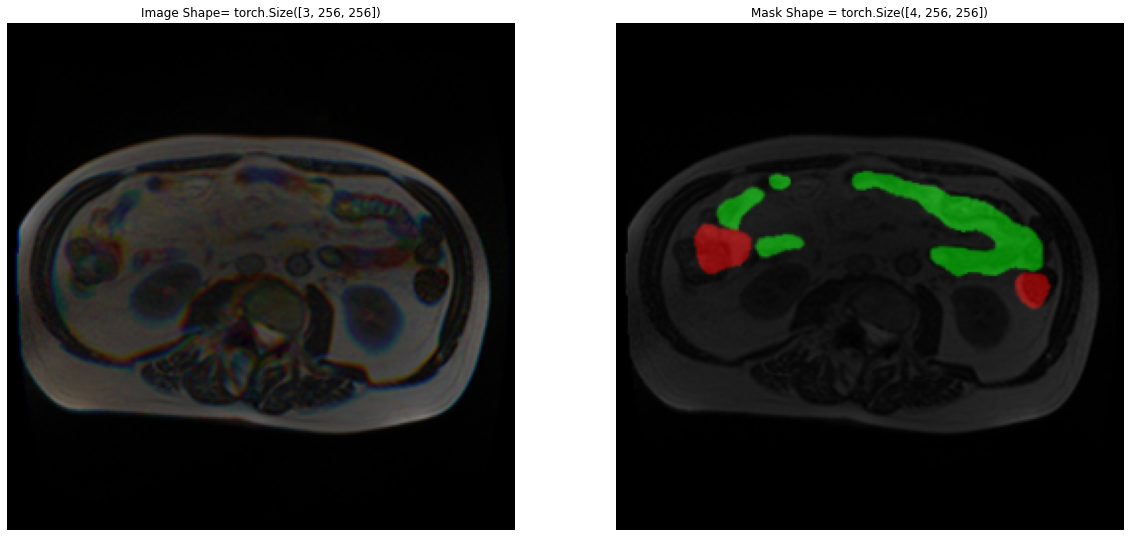

In [48]:
plot_data(dataset[667])

In [28]:
df2d.iloc[667]

large_bowel        32539 8 32897 11 33256 13 33615 15 33974 17 34...
small_bowel        34726 6 35085 8 35444 10 35803 11 36162 12 365...
stomach            33007 9 33364 14 33723 17 34082 19 34441 21 34...
id                                           case102_day0_slice_0092
case_id_str                                                  case102
case_id                                                          102
day_num_str                                                     day0
day_num                                                            0
slice_id                                                  slice_0092
slice_num                                                         92
match                          case102/case102_day0/scans/slice_0092
subpath            case102/case102_day0/scans/slice_0092_360_310_...
filename                            slice_0092_360_310_1.50_1.50.png
im_height                                                        360
im_width                          

### With n fold cross validation we need a dataset for each fold

In [29]:
def prepare_datasets(df, fold, train_transforms, scale_transforms):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)

    train_dataset = Dataset_2_5_from_df(train_df,TRAIN_FOLDER, joint_transform=train_transforms,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    valid_dataset = Dataset_2_5_from_df(valid_df,TRAIN_FOLDER, joint_transform=None,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    
    return train_dataset, valid_dataset

# Training

In [30]:
import segmentation_models_pytorch as smp


## Loss Functions and Metrics

In [31]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False) #required since we are not using index mode

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Training Loops

In [32]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):


    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        #print(images.shape, masks.shape)
        
        output = model(images)

        loss = loss_fn(output, masks)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Softmax(dim=1)(output)
            metric += metric_fn(masks,y_pred) * images.size(0)

        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [33]:
def validatefp32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        
        with torch.no_grad():
            output = model(images)
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Softmax(dim=1)(output)
            metric += metric_fn(masks,y_pred) * images.size(0)
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

## Training

In [34]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')        
        


In [35]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

In [36]:
train_transforms = transforms.Compose(
    [transforms.RandomRotation(4, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomPerspective(distortion_scale=.2, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
    
    ])

In [37]:
scale_transforms = transforms.Compose(
    [squarepad_transform,
    #transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

### Training

In [38]:
init_lr = .001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [39]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4)                    # model output channels (number of classes in your dataset)
    model.cuda()


    
    train_dataset, valid_dataset = prepare_datasets(df25d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=16,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=16,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999
    
    
    for epoch in range(1, epochs + 1):

        #lr = lr_scheduler.get_last_lr()
        lr = optimizer.param_groups[0]['lr']
        #print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.4554, Metric: 0.505,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.3254, Metric = 0.566
Fold: 0, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.2315, Metric: 0.752,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1732, Metric = 0.816
Fold: 0, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1841, Metric: 0.809,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1465, Metric = 0.842
Fold: 0, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1811, Metric: 0.811,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1379, Metric = 0.847
Fold: 0, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1820, Metric: 0.809,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1806, Metric = 0.839
Fold: 0, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1760, Metric: 0.815,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1442, Metric = 0.848
Fold: 0, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1704, Metric: 0.822,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1459, Metric = 0.796
Fold: 0, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1699, Metric: 0.824,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1457, Metric = 0.852
Fold: 0, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1686, Metric: 0.825,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1330, Metric = 0.848
Fold: 0, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1639, Metric: 0.826,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.2021, Metric = 0.839
Fold: 0, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1635, Metric: 0.818,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1504, Metric = 0.832
Fold: 0, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1618, Metric: 0.782,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1430, Metric = 0.843
Fold: 0, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1589, Metric: 0.723,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1259, Metric = 0.813
Fold: 0, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1555, Metric: 0.717,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1284, Metric = 0.786
Fold: 0, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1535, Metric: 0.672,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1247, Metric = 0.718
Fold: 0, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1521, Metric: 0.635,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1228, Metric = 0.628
Fold: 0, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1521, Metric: 0.626,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1249, Metric = 0.634
Fold: 0, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1499, Metric: 0.604,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1211, Metric = 0.592
Fold: 0, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1501, Metric: 0.592,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.577
Fold: 0, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.1491, Metric: 0.583,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1203, Metric = 0.584
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-4b-1.pth
Fold: 1, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.4682, Metric: 0.475,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.3261, Metric = 0.619
Fold: 1, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.2309, Metric: 0.745,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1800, Metric = 0.801
Fold: 1, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1841, Metric: 0.801,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1603, Metric = 0.818
Fold: 1, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1801, Metric: 0.796,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1586, Metric = 0.808
Fold: 1, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1776, Metric: 0.808,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1556, Metric = 0.824
Fold: 1, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1739, Metric: 0.818,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1451, Metric = 0.828
Fold: 1, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1704, Metric: 0.822,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.2492, Metric = 0.810
Fold: 1, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1698, Metric: 0.823,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1463, Metric = 0.827
Fold: 1, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1655, Metric: 0.827,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.2170, Metric = 0.824
Fold: 1, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1643, Metric: 0.831,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1389, Metric = 0.813
Fold: 1, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1632, Metric: 0.830,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1450, Metric = 0.840
Fold: 1, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1616, Metric: 0.834,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1624, Metric = 0.833
Fold: 1, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1581, Metric: 0.836,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1348, Metric = 0.840
Fold: 1, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1572, Metric: 0.839,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1325, Metric = 0.841
Fold: 1, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1547, Metric: 0.830,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1300, Metric = 0.835
Fold: 1, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1523, Metric: 0.833,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1289, Metric = 0.831
Fold: 1, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1516, Metric: 0.830,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1309, Metric = 0.837
Fold: 1, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1501, Metric: 0.842,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1280, Metric = 0.842
Fold: 1, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1508, Metric: 0.843,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1299, Metric = 0.841
Fold: 1, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.1517, Metric: 0.842,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1294, Metric = 0.843
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-4b-1.pth
Fold: 2, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.4781, Metric: 0.516,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.3305, Metric = 0.769
Fold: 2, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.2882, Metric: 0.730,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.2160, Metric = 0.795
Fold: 2, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1890, Metric: 0.800,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1675, Metric = 0.818
Fold: 2, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1805, Metric: 0.808,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1884, Metric = 0.816
Fold: 2, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1756, Metric: 0.814,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1683, Metric = 0.832
Fold: 2, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1732, Metric: 0.815,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.2244, Metric = 0.825
Fold: 2, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1691, Metric: 0.820,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1931, Metric = 0.822
Fold: 2, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1675, Metric: 0.822,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1484, Metric = 0.840
Fold: 2, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1660, Metric: 0.824,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1434, Metric = 0.843
Fold: 2, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1617, Metric: 0.828,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1346, Metric = 0.849
Fold: 2, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1623, Metric: 0.829,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1356, Metric = 0.851
Fold: 2, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1612, Metric: 0.831,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1446, Metric = 0.849
Fold: 2, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1557, Metric: 0.833,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1443, Metric = 0.848
Fold: 2, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1566, Metric: 0.833,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1396, Metric = 0.848
Fold: 2, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1533, Metric: 0.833,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1357, Metric = 0.851
Fold: 2, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1522, Metric: 0.822,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1397, Metric = 0.855
Fold: 2, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1504, Metric: 0.838,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1333, Metric = 0.852
Fold: 2, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1492, Metric: 0.834,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1331, Metric = 0.855
Fold: 2, Epoch: 19, LR: 4.950e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1487, Metric: 0.830,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1324, Metric = 0.856
Fold: 2, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.1494, Metric: 0.829,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1337, Metric = 0.856
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-4b-1.pth
Fold: 3, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.4445, Metric: 0.501,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.2707, Metric = 0.644
Fold: 3, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.2170, Metric: 0.759,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1236, Metric = 0.851
Fold: 3, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1838, Metric: 0.808,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1310, Metric = 0.860
Fold: 3, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1803, Metric: 0.809,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1276, Metric = 0.850
Fold: 3, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1778, Metric: 0.812,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1220, Metric = 0.853
Fold: 3, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1754, Metric: 0.815,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1106, Metric = 0.863
Fold: 3, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1714, Metric: 0.818,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1046, Metric = 0.864
Fold: 3, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1684, Metric: 0.823,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1072, Metric = 0.865
Fold: 3, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1660, Metric: 0.826,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1115, Metric = 0.861
Fold: 3, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1635, Metric: 0.829,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1065, Metric = 0.859
Fold: 3, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1612, Metric: 0.830,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1063, Metric = 0.863
Fold: 3, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1586, Metric: 0.834,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1062, Metric = 0.869
Fold: 3, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1567, Metric: 0.836,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1059, Metric = 0.863
Fold: 3, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1550, Metric: 0.839,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1046, Metric = 0.866
Fold: 3, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1544, Metric: 0.838,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1055, Metric = 0.866
Fold: 3, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1517, Metric: 0.843,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1042, Metric = 0.871
Fold: 3, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1511, Metric: 0.844,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0992, Metric = 0.871
Fold: 3, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1502, Metric: 0.844,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1016, Metric = 0.872
Fold: 3, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1492, Metric: 0.844,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0996, Metric = 0.871
Fold: 3, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.1499, Metric: 0.843,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0990, Metric = 0.871
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-4b-1.pth
Fold: 4, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.4544, Metric: 0.511,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.3162, Metric = 0.728
Fold: 4, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.2386, Metric: 0.763,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1508, Metric = 0.827
Fold: 4, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1826, Metric: 0.807,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1553, Metric = 0.811
Fold: 4, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1818, Metric: 0.808,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1385, Metric = 0.844
Fold: 4, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1794, Metric: 0.810,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1467, Metric = 0.836
Fold: 4, Epoch: 6, LR: 9.357e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1808, Metric: 0.808,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1830, Metric = 0.833
Fold: 4, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1719, Metric: 0.819,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1457, Metric = 0.834
Fold: 4, Epoch: 8, LR: 9.875e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1706, Metric: 0.822,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1296, Metric = 0.849
Fold: 4, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1679, Metric: 0.825,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1309, Metric = 0.848
Fold: 4, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1631, Metric: 0.829,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1377, Metric = 0.853
Fold: 4, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1628, Metric: 0.830,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1428, Metric = 0.853
Fold: 4, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1609, Metric: 0.833,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1344, Metric = 0.847
Fold: 4, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1597, Metric: 0.834,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1282, Metric = 0.855
Fold: 4, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1563, Metric: 0.838,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1217, Metric = 0.856
Fold: 4, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1541, Metric: 0.840,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1216, Metric = 0.858
Fold: 4, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1536, Metric: 0.842,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1205, Metric = 0.856
Fold: 4, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1523, Metric: 0.843,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.860
Fold: 4, Epoch: 18, LR: 1.091e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1521, Metric: 0.844,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1218, Metric = 0.859
Fold: 4, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1503, Metric: 0.845,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1226, Metric = 0.859
Fold: 4, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.1500, Metric: 0.846,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1219, Metric = 0.859
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-4b-1.pth


In [40]:
:::::::

SyntaxError: invalid syntax (3895905085.py, line 1)

### More training

In [65]:
init_lr = .0001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [66]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4)                    # model output channels (number of classes in your dataset)
    model.cuda()


    #Load files from past training to improve apon them
    model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    model.load_state_dict(torch.load(model_in_str))
    
    train_dataset, valid_dataset = prepare_datasets(df25d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999

    for epoch in range(1, epochs + 1):

        lr = lr_scheduler.get_last_lr()
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1471, Metric: 0.576,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.556
Fold: 0, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1462, Metric: 0.564,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.550
Fold: 0, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1473, Metric: 0.549,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1230, Metric = 0.539
Fold: 0, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1474, Metric: 0.536,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1235, Metric = 0.480
Fold: 0, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1457, Metric: 0.506,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1223, Metric = 0.452
Fold: 0, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1480, Metric: 0.422,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1236, Metric = 0.417
Fold: 0, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1456, Metric: 0.448,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1235, Metric = 0.507
Fold: 0, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1460, Metric: 0.474,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1189, Metric = 0.470
Fold: 0, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1466, Metric: 0.464,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.504
Fold: 0, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1465, Metric: 0.460,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1219, Metric = 0.452
Fold: 0, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1451, Metric: 0.439,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1196, Metric = 0.402
Fold: 0, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1459, Metric: 0.423,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1216, Metric = 0.433
Fold: 0, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1460, Metric: 0.407,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1234, Metric = 0.373
Fold: 0, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1454, Metric: 0.398,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1239, Metric = 0.375
Fold: 0, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1434, Metric: 0.402,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.413
Fold: 0, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1448, Metric: 0.411,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1235, Metric = 0.435
Fold: 0, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1451, Metric: 0.411,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1227, Metric = 0.409
Fold: 0, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1449, Metric: 0.402,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1234, Metric = 0.399
Fold: 0, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1450, Metric: 0.398,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1207, Metric = 0.396
Fold: 0, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3704 [00:00<?, ?it/s]

Training-- Loss: 0.1444, Metric: 0.398,

  0%|          | 0/1108 [00:00<?, ?it/s]

Validation-- Loss: 0.1227, Metric = 0.393
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-4b-2.pth
Fold: 1, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1488, Metric: 0.838,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1299, Metric = 0.842
Fold: 1, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1473, Metric: 0.840,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1273, Metric = 0.843
Fold: 1, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1474, Metric: 0.839,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1271, Metric = 0.841
Fold: 1, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1476, Metric: 0.832,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1303, Metric = 0.837
Fold: 1, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1481, Metric: 0.828,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1315, Metric = 0.833
Fold: 1, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1484, Metric: 0.829,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1290, Metric = 0.836
Fold: 1, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1469, Metric: 0.825,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1302, Metric = 0.823
Fold: 1, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1480, Metric: 0.812,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1338, Metric = 0.810
Fold: 1, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1464, Metric: 0.818,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1346, Metric = 0.811
Fold: 1, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1481, Metric: 0.798,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1269, Metric = 0.828
Fold: 1, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1450, Metric: 0.784,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1303, Metric = 0.815
Fold: 1, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1456, Metric: 0.770,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1304, Metric = 0.788
Fold: 1, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1461, Metric: 0.749,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1303, Metric = 0.810
Fold: 1, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1447, Metric: 0.743,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1314, Metric = 0.748
Fold: 1, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1470, Metric: 0.729,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1308, Metric = 0.764
Fold: 1, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1446, Metric: 0.708,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1309, Metric = 0.752
Fold: 1, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1440, Metric: 0.703,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1304, Metric = 0.711
Fold: 1, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1437, Metric: 0.697,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1278, Metric = 0.738
Fold: 1, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1453, Metric: 0.700,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1301, Metric = 0.747
Fold: 1, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3700 [00:00<?, ?it/s]

Training-- Loss: 0.1455, Metric: 0.703,

  0%|          | 0/1112 [00:00<?, ?it/s]

Validation-- Loss: 0.1294, Metric = 0.734
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-4b-2.pth
Fold: 2, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1471, Metric: 0.804,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1301, Metric = 0.835
Fold: 2, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1480, Metric: 0.792,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1296, Metric = 0.818
Fold: 2, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1469, Metric: 0.776,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1320, Metric = 0.772
Fold: 2, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1475, Metric: 0.805,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1347, Metric = 0.828
Fold: 2, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1465, Metric: 0.798,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1319, Metric = 0.843
Fold: 2, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1456, Metric: 0.785,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1317, Metric = 0.829
Fold: 2, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1468, Metric: 0.763,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1362, Metric = 0.676
Fold: 2, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1476, Metric: 0.744,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1322, Metric = 0.774
Fold: 2, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1451, Metric: 0.744,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1329, Metric = 0.732
Fold: 2, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1478, Metric: 0.714,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1378, Metric = 0.661
Fold: 2, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1449, Metric: 0.731,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1309, Metric = 0.663
Fold: 2, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1460, Metric: 0.719,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1369, Metric = 0.673
Fold: 2, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1449, Metric: 0.735,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1344, Metric = 0.664
Fold: 2, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1452, Metric: 0.712,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1327, Metric = 0.661
Fold: 2, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1462, Metric: 0.701,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1334, Metric = 0.667
Fold: 2, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1448, Metric: 0.689,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1327, Metric = 0.662
Fold: 2, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1461, Metric: 0.672,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1351, Metric = 0.655
Fold: 2, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1437, Metric: 0.659,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1352, Metric = 0.656
Fold: 2, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1437, Metric: 0.662,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1341, Metric = 0.654
Fold: 2, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/4002 [00:00<?, ?it/s]

Training-- Loss: 0.1435, Metric: 0.662,

  0%|          | 0/810 [00:00<?, ?it/s]

Validation-- Loss: 0.1327, Metric = 0.660
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-4b-2.pth
Fold: 3, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1477, Metric: 0.839,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0994, Metric = 0.869
Fold: 3, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1475, Metric: 0.840,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0989, Metric = 0.871
Fold: 3, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1475, Metric: 0.839,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0976, Metric = 0.867
Fold: 3, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1472, Metric: 0.840,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.1004, Metric = 0.871
Fold: 3, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1476, Metric: 0.839,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.1001, Metric = 0.866
Fold: 3, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1473, Metric: 0.842,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0995, Metric = 0.869
Fold: 3, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1467, Metric: 0.839,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0991, Metric = 0.867
Fold: 3, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1458, Metric: 0.841,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0986, Metric = 0.865
Fold: 3, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1458, Metric: 0.838,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0998, Metric = 0.858
Fold: 3, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1453, Metric: 0.838,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0942, Metric = 0.871
Fold: 3, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1464, Metric: 0.838,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0977, Metric = 0.869
Fold: 3, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1447, Metric: 0.836,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0963, Metric = 0.863
Fold: 3, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1450, Metric: 0.833,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.1029, Metric = 0.862
Fold: 3, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1462, Metric: 0.830,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0973, Metric = 0.860
Fold: 3, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1439, Metric: 0.827,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0977, Metric = 0.870
Fold: 3, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1437, Metric: 0.834,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0973, Metric = 0.851
Fold: 3, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1448, Metric: 0.829,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0992, Metric = 0.866
Fold: 3, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1440, Metric: 0.822,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0975, Metric = 0.860
Fold: 3, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1439, Metric: 0.824,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0976, Metric = 0.867
Fold: 3, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3916 [00:00<?, ?it/s]

Training-- Loss: 0.1430, Metric: 0.823,

  0%|          | 0/896 [00:00<?, ?it/s]

Validation-- Loss: 0.0968, Metric = 0.834
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-4b-2.pth
Fold: 4, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1486, Metric: 0.845,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1191, Metric = 0.859
Fold: 4, Epoch: 2, LR: 1.043e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1491, Metric: 0.844,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.858
Fold: 4, Epoch: 3, LR: 2.800e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1485, Metric: 0.845,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1203, Metric = 0.857
Fold: 4, Epoch: 4, LR: 5.200e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1472, Metric: 0.846,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.859
Fold: 4, Epoch: 5, LR: 7.600e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1488, Metric: 0.845,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1234, Metric = 0.858
Fold: 4, Epoch: 6, LR: 9.357e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1474, Metric: 0.845,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1196, Metric = 0.859
Fold: 4, Epoch: 7, LR: 1.000e-04--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1491, Metric: 0.845,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1206, Metric = 0.855
Fold: 4, Epoch: 8, LR: 9.875e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1479, Metric: 0.845,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1189, Metric = 0.854
Fold: 4, Epoch: 9, LR: 9.505e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1474, Metric: 0.845,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1206, Metric = 0.854
Fold: 4, Epoch: 10, LR: 8.909e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1477, Metric: 0.846,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1256, Metric = 0.857
Fold: 4, Epoch: 11, LR: 8.117e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1468, Metric: 0.847,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1242, Metric = 0.855
Fold: 4, Epoch: 12, LR: 7.169e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1466, Metric: 0.846,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1233, Metric = 0.857
Fold: 4, Epoch: 13, LR: 6.112e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1467, Metric: 0.846,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1234, Metric = 0.856
Fold: 4, Epoch: 14, LR: 5.000e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1455, Metric: 0.847,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.857
Fold: 4, Epoch: 15, LR: 3.887e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1450, Metric: 0.848,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1251, Metric = 0.855
Fold: 4, Epoch: 16, LR: 2.830e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1440, Metric: 0.848,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1238, Metric = 0.857
Fold: 4, Epoch: 17, LR: 1.882e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1457, Metric: 0.847,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.857
Fold: 4, Epoch: 18, LR: 1.091e-05--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1456, Metric: 0.847,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1261, Metric = 0.856
Fold: 4, Epoch: 19, LR: 4.951e-06--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1456, Metric: 0.847,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1246, Metric = 0.856
Fold: 4, Epoch: 20, LR: 1.253e-06--

  0%|          | 0/3926 [00:00<?, ?it/s]

Training-- Loss: 0.1450, Metric: 0.848,

  0%|          | 0/886 [00:00<?, ?it/s]

Validation-- Loss: 0.1217, Metric = 0.857
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-4b-2.pth


In [ ]:
::::::::::::::::::::::::: #Stop

## Do some trial inference on the validation set

In [41]:
model_name_base = "Unet-4b"
model = smp.Unet(
encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#encoder_weights=None,
in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=4)                    # model output channels (number of classes in your dataset)
model.cuda();

In [42]:
#Select the fold=0 model for this
fold = 0

model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
model.load_state_dict(torch.load(model_in_str))

<All keys matched successfully>

In [43]:
train_dataset, valid_dataset = prepare_datasets(df25d, fold, train_transforms, scale_transforms)


valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=16,
                                               num_workers=10,
                                               pin_memory=True,
                                               shuffle=True)

In [44]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [45]:
output = torch.nn.Softmax(1)(output)
#output = torch.nn.Softmax(1)(output)

In [49]:
def plot_result25(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(rearrange(data['image'][idx].numpy(),'c h w -> h w c'), vmin=0, vmax=1.0, aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(rearrange(data['mask'][idx][0:3,:,:].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx][0:3,:,:].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx][1].numpy(),cmap='gray', vmin=0, vmax=1.0,aspect=ratio)
    plt.imshow(rearrange(output[idx][0:3,:,:].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

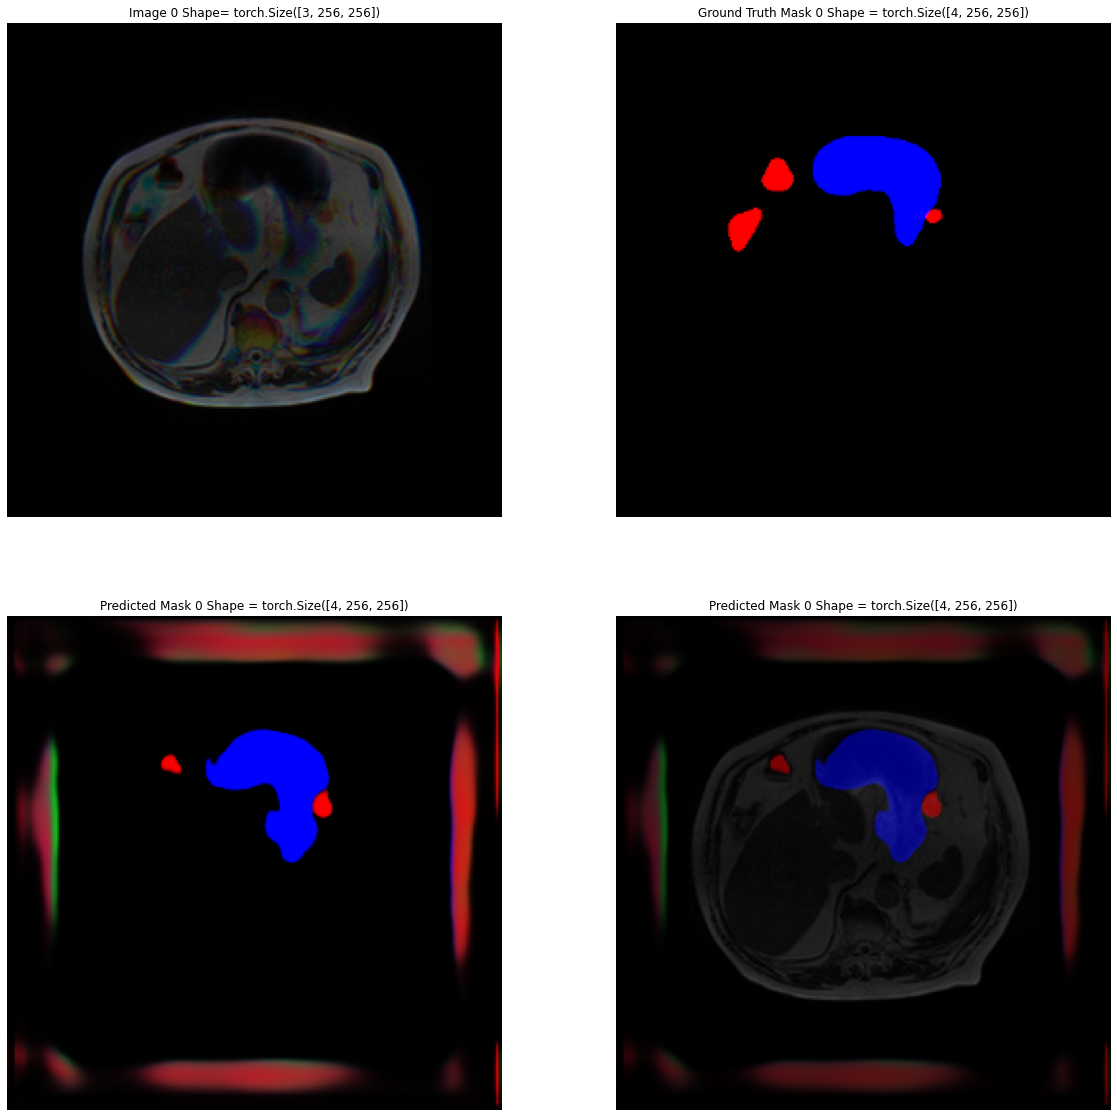

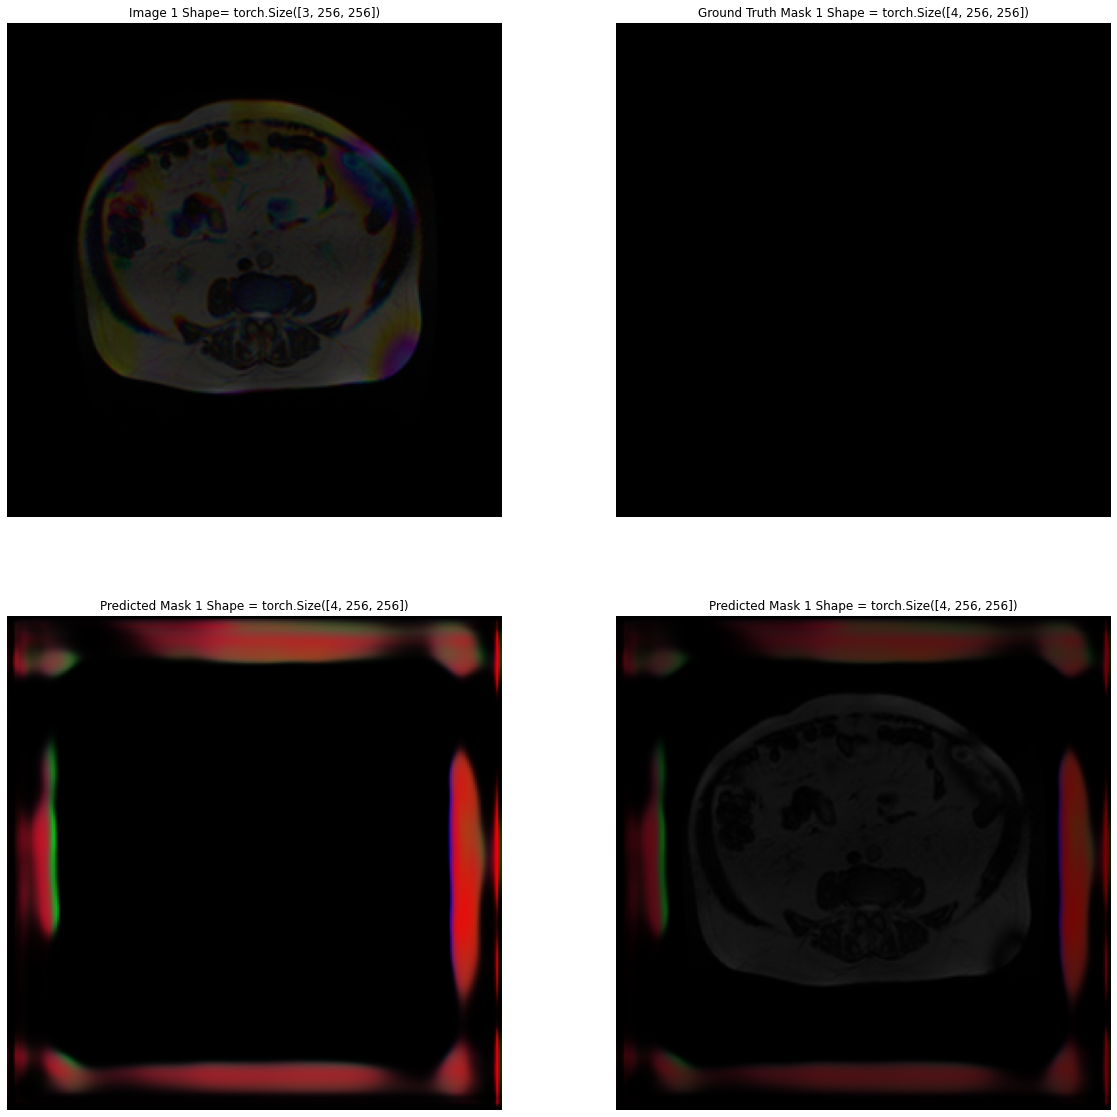

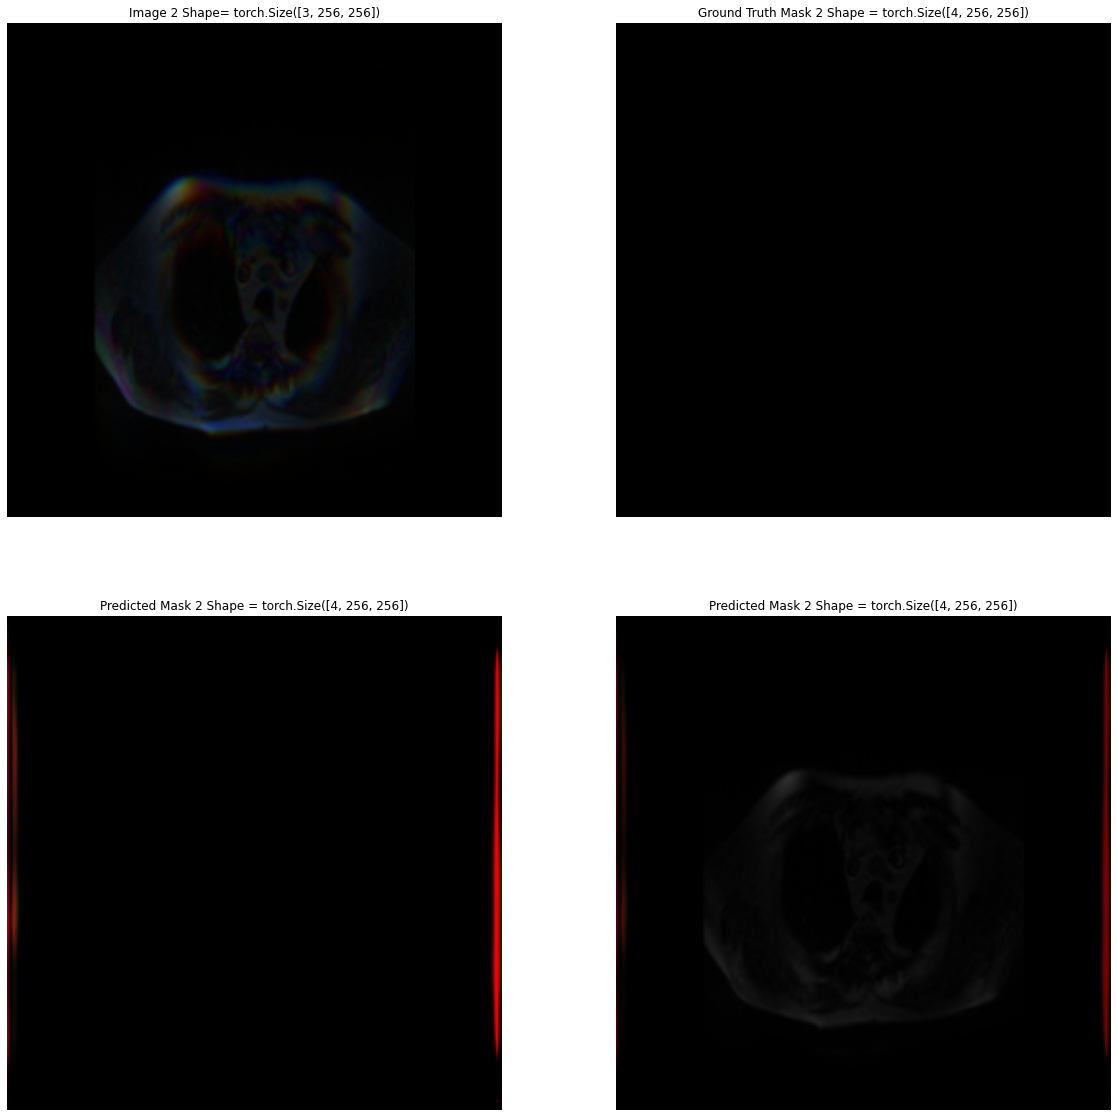

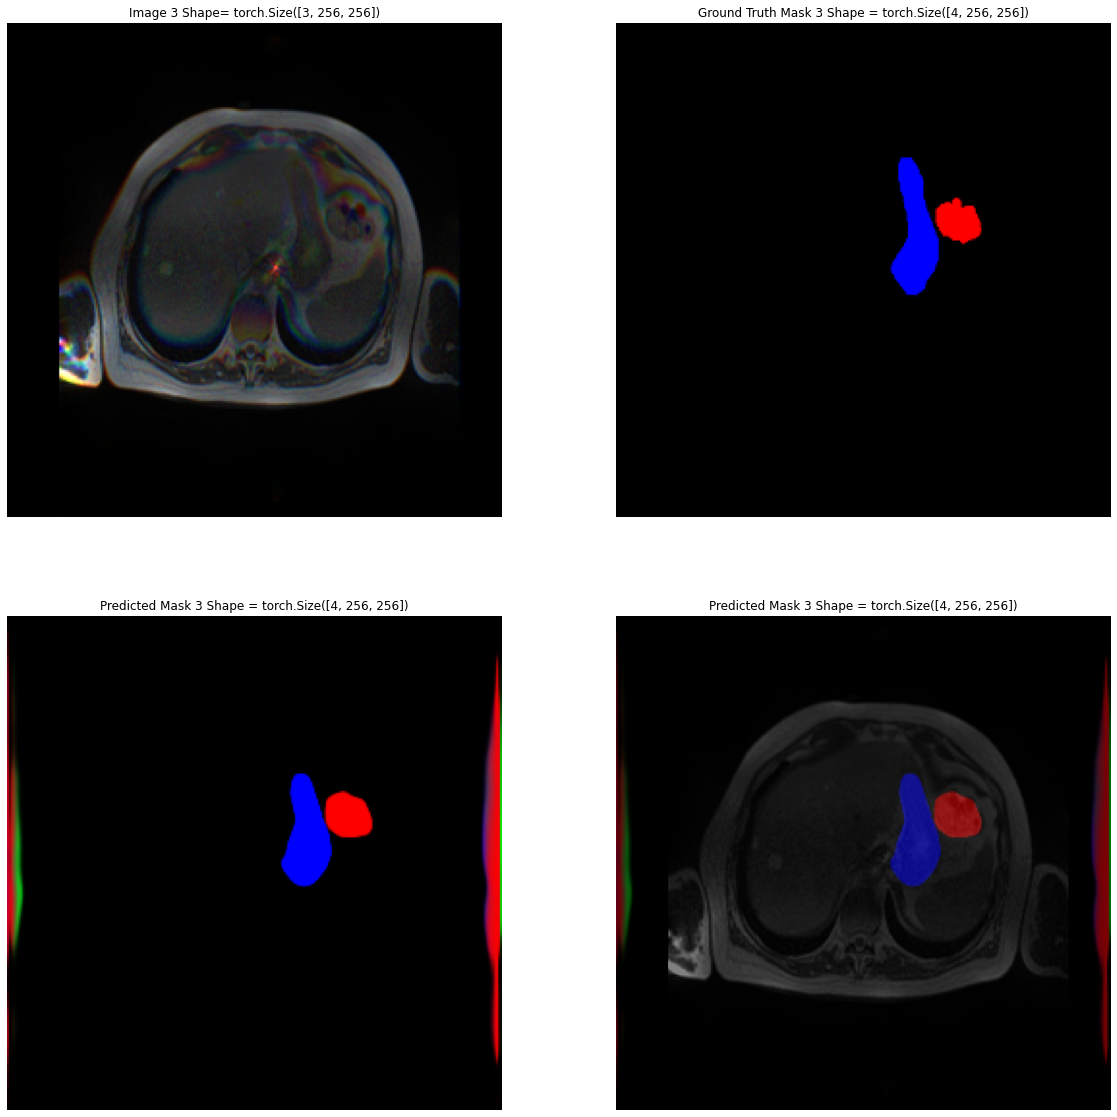

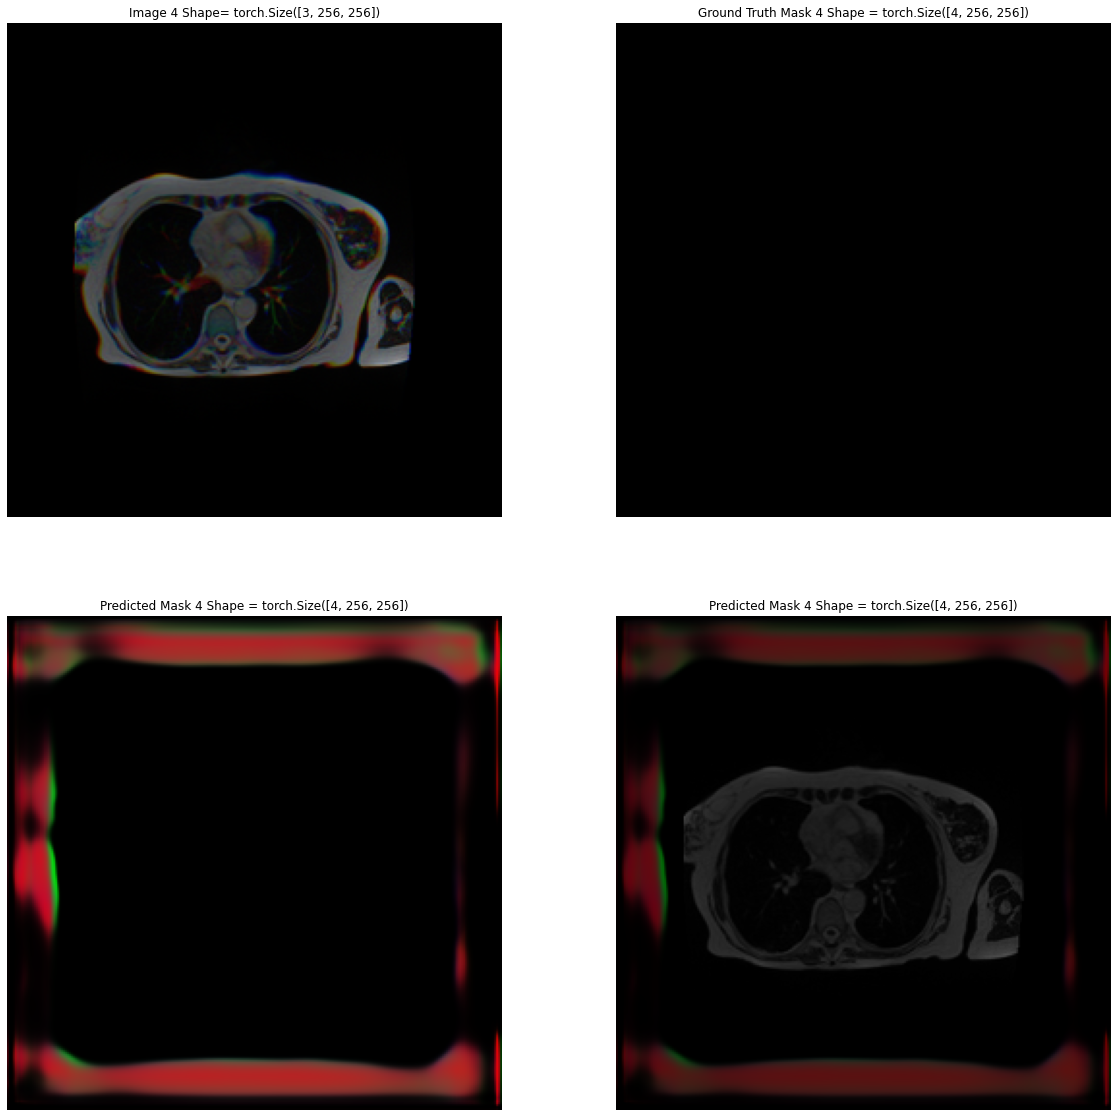

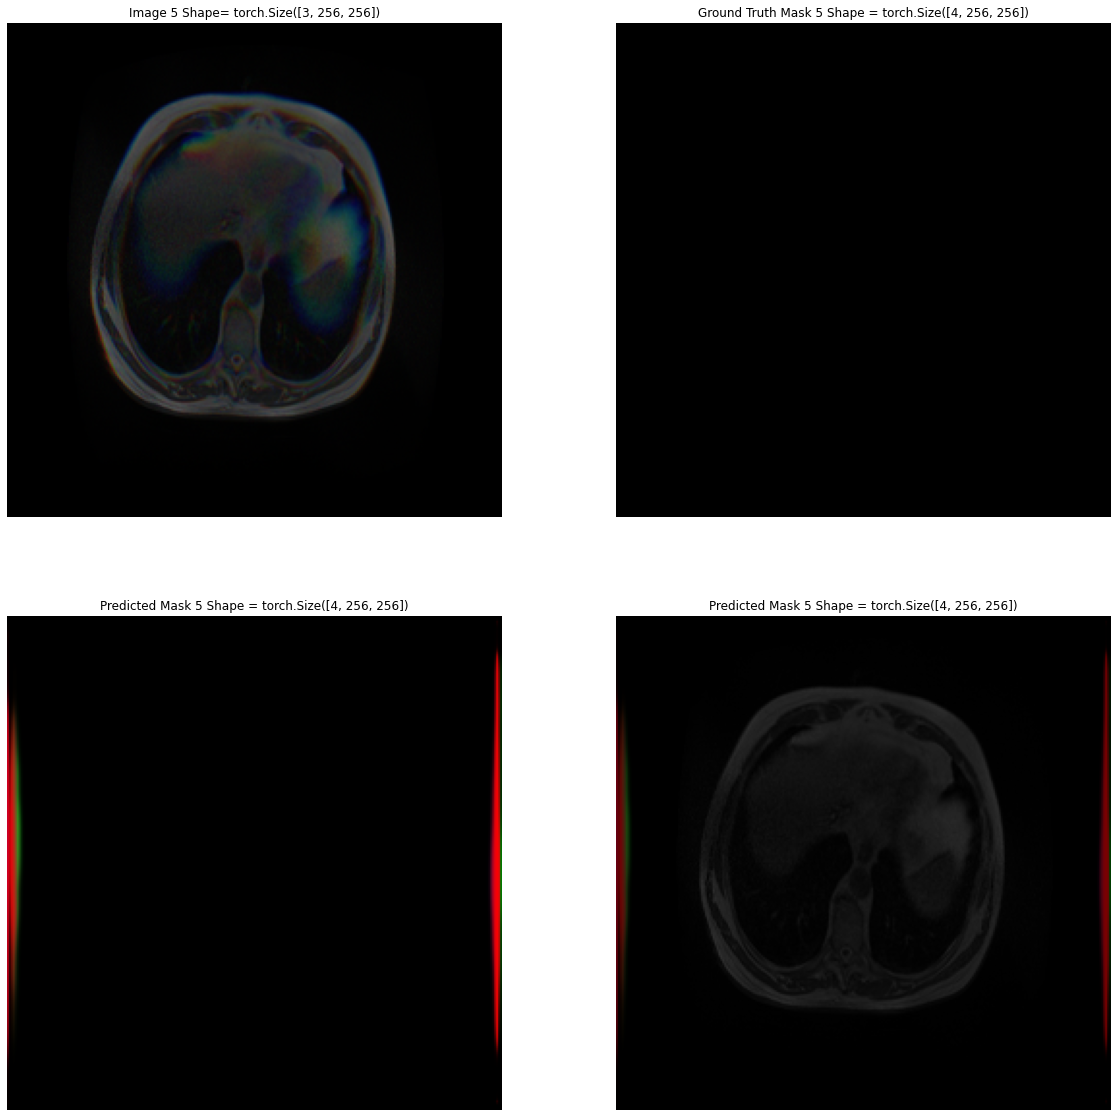

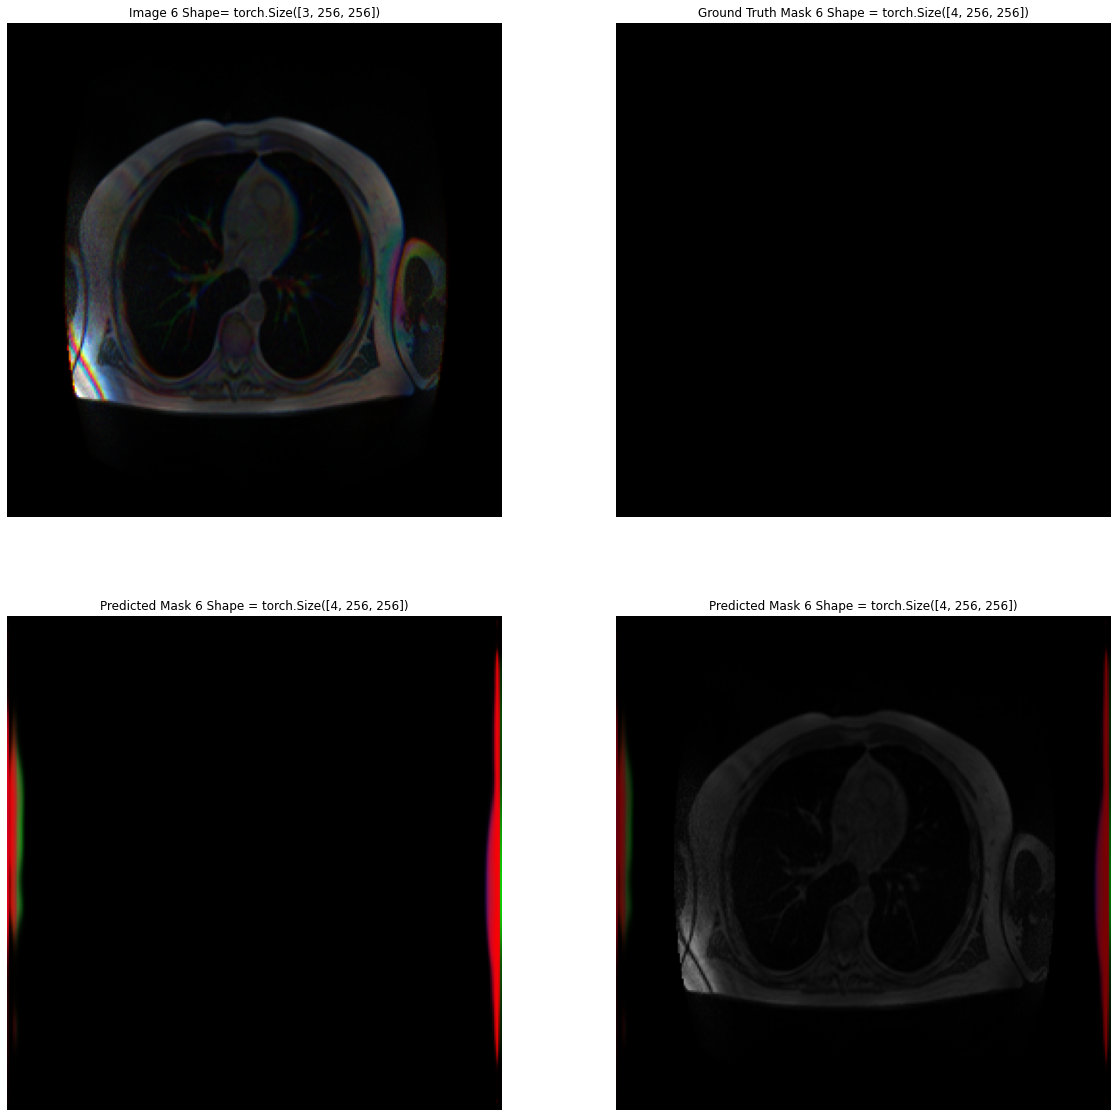

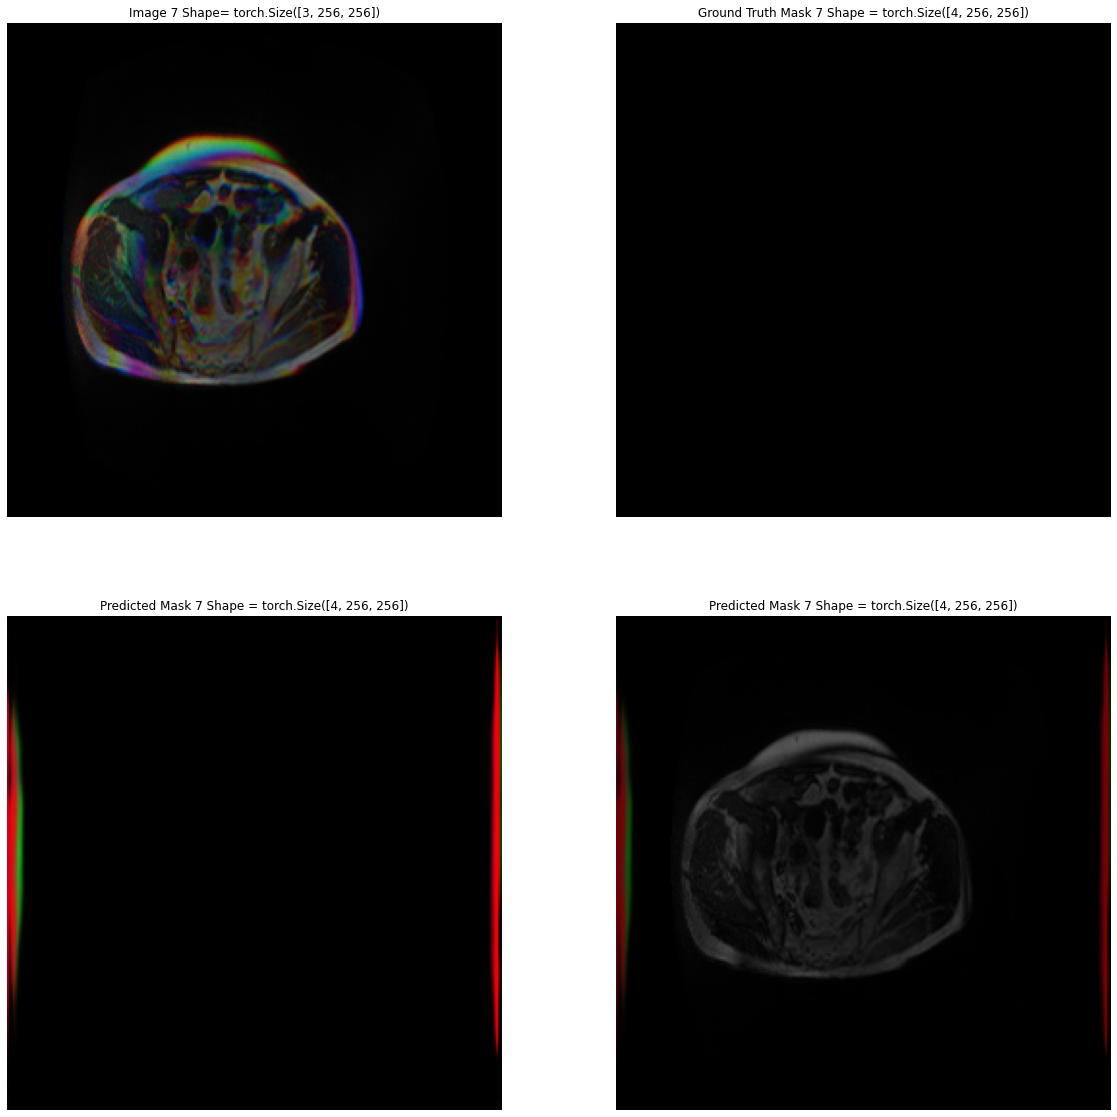

In [50]:
for idx in range(0,8):
    plot_result25(data=data, output=output, idx=idx)

## Calculate the error metrics on the validation folds

In [51]:
df25d['ilocid']=list(range(0,df25d.shape[0]))

In [52]:
def validatefp32_detail(valid_dataloader, loss_fn, metric_fn, model,res):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    
    for batch in valid_dataloader:
        images, masks, idx = batch['image'], batch['mask'], batch['idx']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        
        with torch.no_grad():
            output = model(images)
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Softmax(1)(output)
            m_calc = metric_fn(masks,y_pred)
            metric += m_calc.sum()
            res[idx] = m_calc.cpu()
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric, res

In [53]:
def dice_coef_batch(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1))
    return dice

In [54]:
def prepare_valid_dataset(df, fold, scale_transforms):
    valid_df = df.query("fold==@fold").reset_index(drop=True)

    valid_dataset = Dataset_2_5_from_df(valid_df,TRAIN_FOLDER, joint_transform=None,
                                   image_transform=scale_transforms, mask_transform=scale_transforms,ret_idx=True)
    
    return valid_dataset

In [55]:
model_name = "Unet-4b-1.pth"
loss_fn = criterion
metric_fn = dice_coef_batch
n_folds = int(df25d['fold'].max()) + 1

Return the actual file id and the metric

In [56]:

mean_metric = 0
res = torch.zeros((df25d.shape[0]))

for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name) 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()

    valid_dataset = prepare_valid_dataset(df25d, fold, scale_transforms)
    

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    

        
    validation_loss, validation_metric,res = validatefp32_detail(valid_dataloader,
                                                                  loss_fn,
                                                                  metric_fn,
                                                                  model,
                                                                res)



    print('Fold-{}- Loss: {:.4f}, Metric = {:.3f}'.format(fold, validation_loss, validation_metric))
    
    
    
    
    mean_metric = mean_metric + validation_metric
    
print("Mean metric =",mean_metric/n_folds)    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-4b-1.pth


  0%|          | 0/1108 [00:00<?, ?it/s]

Fold-0- Loss: 0.1202, Metric = 0.584
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-4b-1.pth


  0%|          | 0/1112 [00:00<?, ?it/s]

Fold-1- Loss: 0.1313, Metric = 0.843
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-4b-1.pth


  0%|          | 0/810 [00:00<?, ?it/s]

Fold-2- Loss: 0.1299, Metric = 0.856
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-4b-1.pth


  0%|          | 0/896 [00:00<?, ?it/s]

Fold-3- Loss: 0.0981, Metric = 0.871
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-4b-1.pth


  0%|          | 0/886 [00:00<?, ?it/s]

Fold-4- Loss: 0.1199, Metric = 0.859
Mean metric = tensor(0.8027, device='cuda:0')


In [57]:
df25d['dice'] = res.numpy()

In [58]:
df25d.columns

Index(['large_bowel', 'small_bowel', 'stomach', 'id', 'case_id_str', 'case_id',
       'day_num_str', 'day_num', 'slice_id', 'slice_num', 'match', 'subpath',
       'filename', 'im_height', 'im_width', 'im_pixel_height',
       'im_pixel_width', 'slice_thickness', 'segmentations', 'fold', 'max',
       'max_img', 'subpath_plus', 'subpath_minus', 'ilocid', 'dice'],
      dtype='object')

In [59]:
df25d.to_csv(DATASET_FOLDER/"results/df25d_4b.csv")

In [67]:
model_name = "Unet-4b-2.pth"
loss_fn = criterion
metric_fn = dice_coef_batch
n_folds = int(df25d['fold'].max()) + 1

In [68]:
mean_metric = 0
res = torch.zeros((df25d.shape[0]))

for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name) 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()

    valid_dataset = prepare_valid_dataset(df25d, fold, scale_transforms)
    

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    

        
    validation_loss, validation_metric,res = validatefp32_detail(valid_dataloader,
                                                                  loss_fn,
                                                                  metric_fn,
                                                                  model,
                                                                res)



    print('Fold-{}- Loss: {:.4f}, Metric = {:.3f}'.format(fold, validation_loss, validation_metric))
    
    
    
    
    mean_metric = mean_metric + validation_metric
    
print("Mean metric =",mean_metric/n_folds)    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-4b-2.pth


  0%|          | 0/1108 [00:00<?, ?it/s]

Fold-0- Loss: 0.1226, Metric = 0.393
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-4b-2.pth


  0%|          | 0/1112 [00:00<?, ?it/s]

Fold-1- Loss: 0.1285, Metric = 0.734
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-4b-2.pth


  0%|          | 0/810 [00:00<?, ?it/s]

Fold-2- Loss: 0.1310, Metric = 0.660
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-4b-2.pth


  0%|          | 0/896 [00:00<?, ?it/s]

Fold-3- Loss: 0.0968, Metric = 0.834
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-4b-2.pth


  0%|          | 0/886 [00:00<?, ?it/s]

Fold-4- Loss: 0.1211, Metric = 0.857
Mean metric = tensor(0.6956, device='cuda:0')


<AxesSubplot:xlabel='fold', ylabel='dice'>

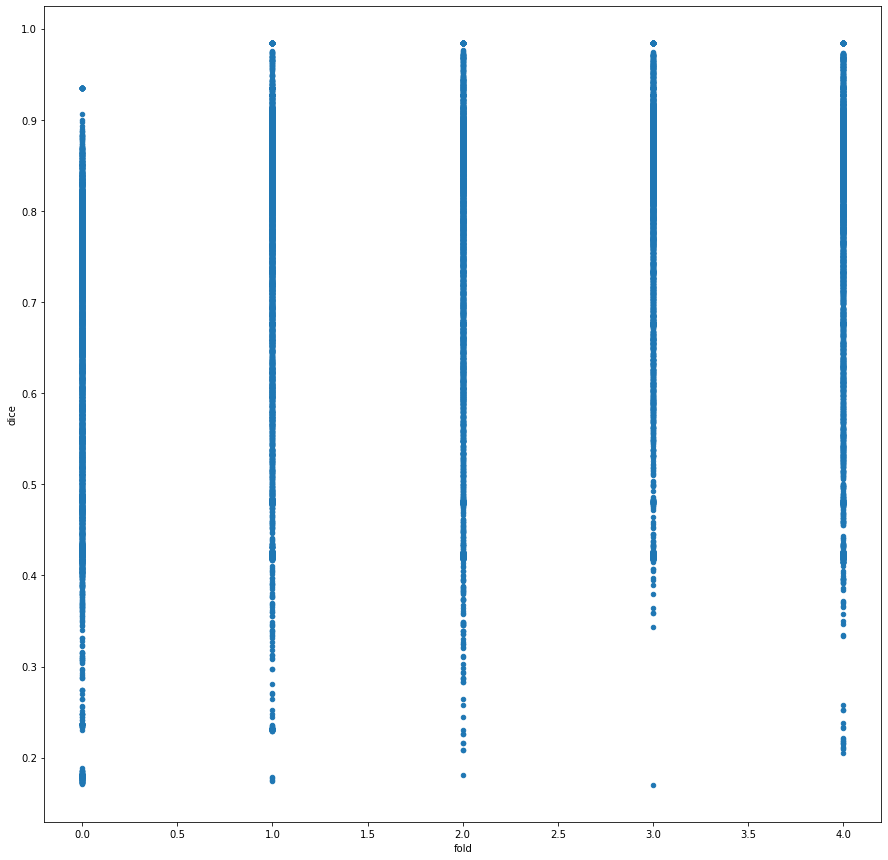

In [69]:
df25d.plot(x='fold',y='dice',kind='scatter',figsize=(15,15))

array([<AxesSubplot:title={'center':'0.0'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'1.0'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'2.0'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'3.0'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'4.0'}, ylabel='Frequency'>],
      dtype=object)

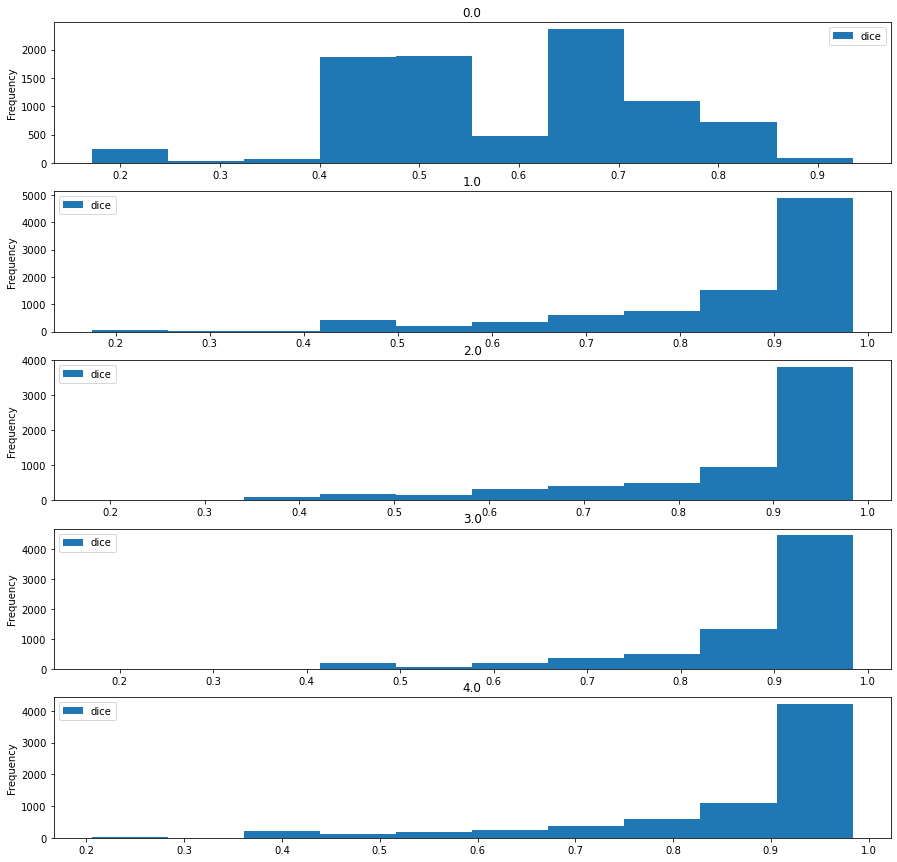

In [70]:
df25d.plot.hist(column='dice',by=['fold'],figsize=(15,15))

In [62]:
df = pd.DataFrame(df25d.groupby("slice_num")["dice"].mean())

In [63]:
list(df['dice'])

[0.8795999884605408,
 0.8736141324043274,
 0.860694408416748,
 0.8618444800376892,
 0.8621228933334351,
 0.8567450046539307,
 0.8495336174964905,
 0.8467385768890381,
 0.8456212282180786,
 0.8421358466148376,
 0.8425180315971375,
 0.8425979614257812,
 0.8468614816665649,
 0.8446382284164429,
 0.8425427675247192,
 0.8447955250740051,
 0.8451876640319824,
 0.8435291647911072,
 0.8450561165809631,
 0.8383212089538574,
 0.8407992124557495,
 0.8377348780632019,
 0.8400454521179199,
 0.8356382250785828,
 0.8403806686401367,
 0.8378154039382935,
 0.8344761729240417,
 0.8335005044937134,
 0.834536612033844,
 0.835552990436554,
 0.8364067077636719,
 0.838223934173584,
 0.8360284566879272,
 0.8367396593093872,
 0.8383767604827881,
 0.8418182134628296,
 0.8410217761993408,
 0.8384736180305481,
 0.8411471843719482,
 0.8393413424491882,
 0.8406326770782471,
 0.8354584574699402,
 0.8322424292564392,
 0.8297188878059387,
 0.8271288871765137,
 0.8254172801971436,
 0.8266586661338806,
 0.82569158077239

In [64]:
del model
del output
torch.cuda.empty_cache()

In [ ]:
train_dataset[0]

In [ ]:
del output

In [71]:
sel = (df25d['fold'] == 0) & (df25d['id'] == 'case7_day0_slice0001')

In [72]:
df25d.loc[sel]

Empty DataFrame
Columns: [large_bowel, small_bowel, stomach, id, case_id_str, case_id, day_num_str, day_num, slice_id, slice_num, match, subpath, filename, im_height, im_width, im_pixel_height, im_pixel_width, slice_thickness, segmentations, fold, max, max_img, subpath_plus, subpath_minus, ilocid, dice]
Index: []

[0 rows x 26 columns]